In [70]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt # library to plot graph

In [71]:
dataSet=pd.read_csv("../input_data/train.csv")

In [72]:
def makeDict(temp):
    a=np.array(temp)
    unique, counts=np.unique(a,return_counts=True)
    return dict(zip(unique,counts))

In [73]:
def calcEntropy(q):
    if q==0 or q==1:
        return 0
    return -(q*math.log2(q) + (1-q)*math.log2(1-q))

In [74]:
def classifyData(data):
    for item in data:
        temp=makeDict(data[item])
        if(len(temp)>10):
            x=len(temp)//10 + 1
            listOfKeys=list(temp.keys())
            newCol=[]
            for row in data[item]:
                ind=listOfKeys.index(row)
                upperBorder=(ind//x + 1)*x
                if(upperBorder>=len(temp)):
                    upperBorder=-1
                newCol.append(listOfKeys[upperBorder])
            data[item]=newCol
    return data

In [75]:
def calcBestAttr(entropy,data):
    iGains={}
    for col in data:
        if(col=="left"):
            continue
        uValCount=makeDict(data[col])
        wAvg=0
        for category in uValCount:
            a=data[(data[col]==category) & (data['left']==1)]
            q=len(a)/uValCount[category]
            wAvg+=((uValCount[category]/len(data))*calcEntropy(q))
        iGains[col]=entropy-wAvg
    try:
        maxCategory = max(iGains.keys(), key=(lambda k: iGains[k]))
    except:
        return None
    return maxCategory

In [76]:
def predict(model,root,sample):
    key=list(root.keys())[0]
    if(key=='value'):
        return root[key]
    try:
        root=root[key]
        if sample[key] in root.keys():
            return predict(model,root[sample[key]],sample)
        else:
            for k in root.keys():
                if(sample[key]<=k):
                    return predict(model,root[k],sample)
            return 0
    except:
        return 0

In [77]:
def predictChars(data):
    truePositive,falsePositive,trueNegative,falseNegative=0,0,0,0
    for sample in data:
        pred_label=predict(DTree,DTree,sample)
        if(pred_label==sample['left']):
            if(pred_label):
                truePositive+=1
            else:
                trueNegative+=1
        else:
            if(pred_label):
                falsePositive+=1
            else:
                falseNegative+=1
    accuracy=(truePositive+trueNegative)*100/len(data)
    return accuracy

In [78]:
inputData=dataSet

In [79]:
trainingData=inputData.sample(frac=0.8)
validationData=inputData.drop(trainingData.index)
trainingData=classifyData(trainingData)

In [80]:
def makeTree(root,data,errorData):
    a=len(data[data.left==1])
    if(a==0 or a==len(data)):
        root.update({'value':1 if a else 0})
        return
    q=a/len(data)
    newNode=calcBestAttr(calcEntropy(q),data)
    if(newNode is None):
        b=len(data)-a
        if(a>=b):
            root.update({'value':1})
        else:
            root.update({'value':0})
        return
    root.update({newNode:{}})
    global nodeCounter
    nodeCounter+=1 # incrementing the nodecount to plot graph
    acc=predictChars(errorData.to_dict('records')) # calculating the accuracy after each node creation
    accuracies.append(acc)
    nodes.append(nodeCounter)
    root=root[newNode]
    for category in np.unique(data[newNode]):
        root.update({category:{}})
        temp=data[data[newNode]==category]
        makeTree(root[category],temp.drop(columns=[newNode]),errorData)

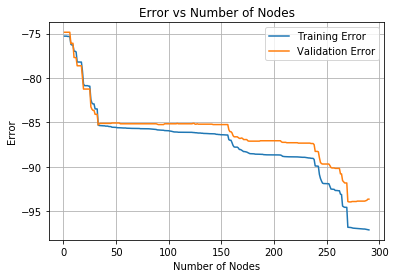

In [81]:
# making a common graph for validation and training error vs number of nodes
DTree={}
nodeCounter=0
accuracies=[]
nodes=[]
makeTree(DTree,trainingData,trainingData)
error=[]
for acc in accuracies:
    error.append(1-acc)
plt.plot(nodes,error,label="Training Error")

DTree={}
nodeCounter=0
accuracies=[]
nodes=[]
makeTree(DTree,trainingData,validationData)
error=[]
for acc in accuracies:
    error.append(1-acc)
plt.plot(nodes,error,label="Validation Error")
plt.xlabel('Number of Nodes')
plt.ylabel('Error')
plt.title('Error vs Number of Nodes')
plt.grid(True)
plt.legend()
plt.show()